<a href="https://colab.research.google.com/github/trilgar/MSM-2021/blob/main/autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [224]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torchvision.utils import save_image

In [225]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [226]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

tensor_transform = transforms.ToTensor()
dataset = datasets.MNIST(root = "./data",
                         train = True,
                         download = True,
                         transform = tensor_transform)
loader = torch.utils.data.DataLoader(dataset = dataset,
                                     batch_size = 32,
                                     shuffle = True)
loader = DeviceDataLoader(loader, device)

In [227]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
          
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 9
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18)
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 28 * 28),
            torch.nn.Sigmoid()
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [228]:
# Model Initialization
model = AE()
model.to(device)
  
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
  
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-1,
                             weight_decay = 1e-8)

Epoch [1/5], Step [500/1875], Loss: 0.1421
Epoch [1/5], Step [1000/1875], Loss: 0.1415
Epoch [1/5], Step [1500/1875], Loss: 0.1458


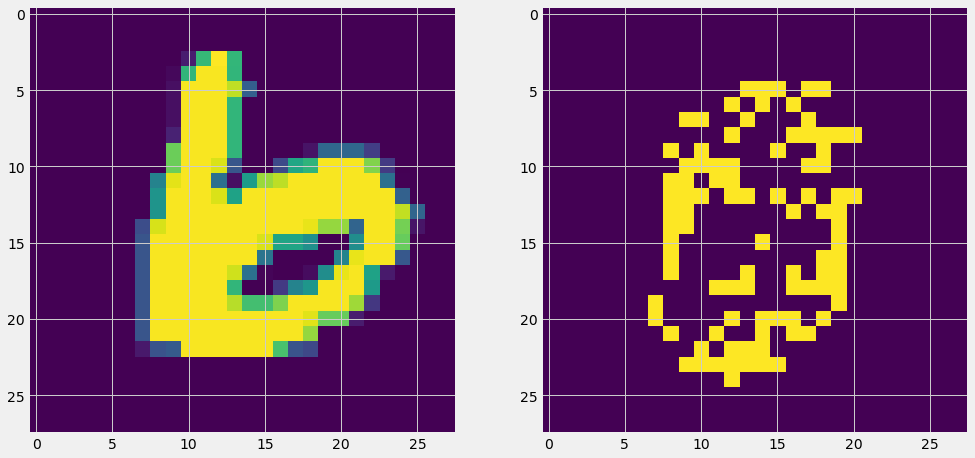

Epoch [2/5], Step [500/1875], Loss: 0.1478
Epoch [2/5], Step [1000/1875], Loss: 0.1428
Epoch [2/5], Step [1500/1875], Loss: 0.1451


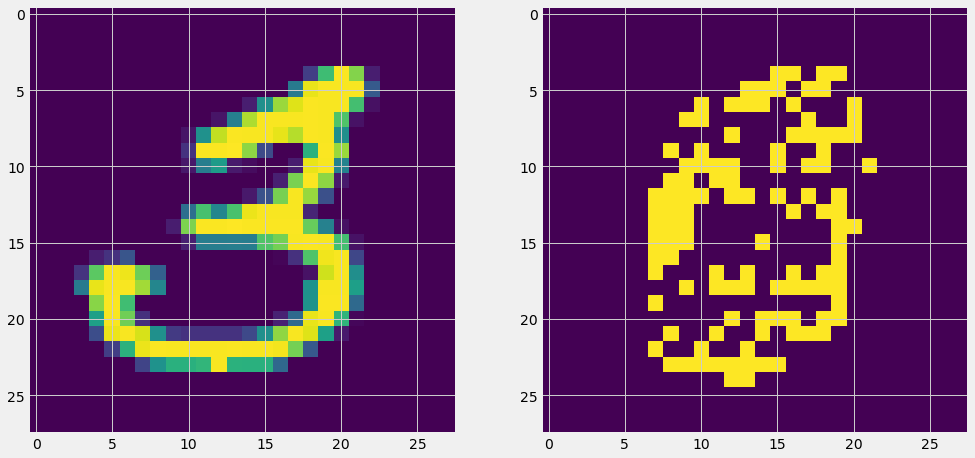

Epoch [3/5], Step [500/1875], Loss: 0.2199
Epoch [3/5], Step [1000/1875], Loss: 0.2263
Epoch [3/5], Step [1500/1875], Loss: 0.2286


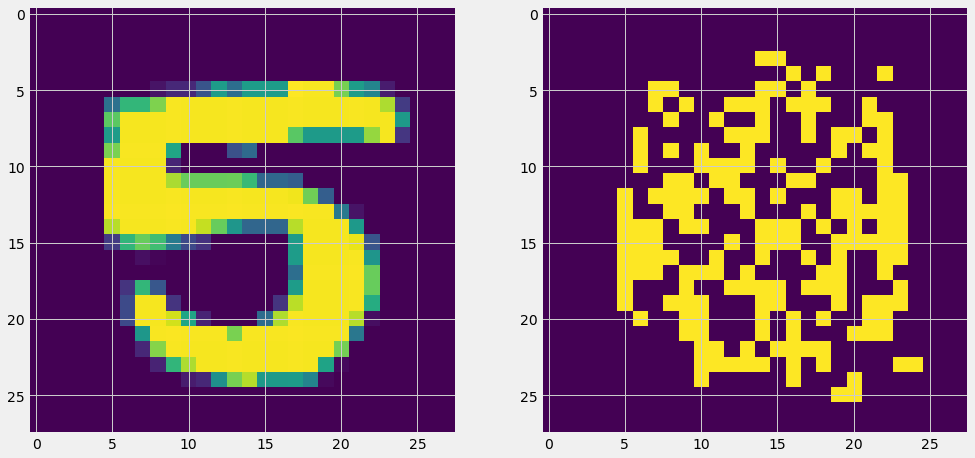

Epoch [4/5], Step [500/1875], Loss: 0.2247
Epoch [4/5], Step [1000/1875], Loss: 0.2400
Epoch [4/5], Step [1500/1875], Loss: 0.2326


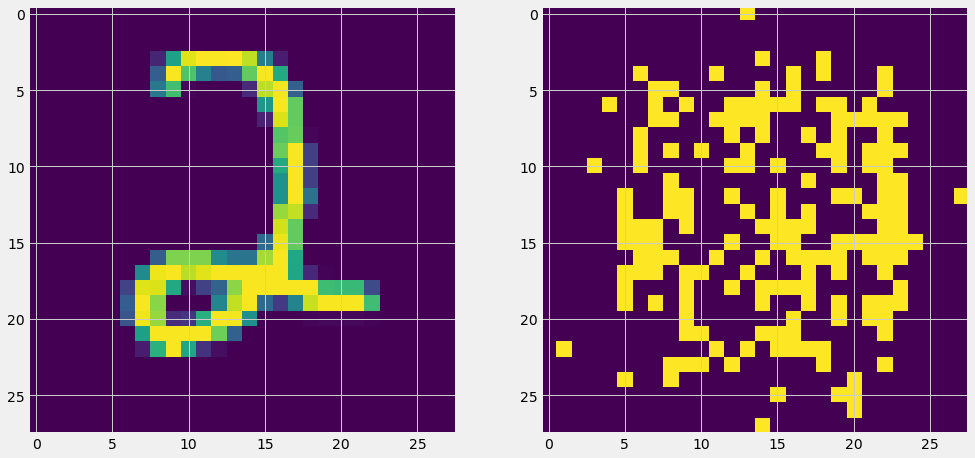

Epoch [5/5], Step [500/1875], Loss: 0.2145
Epoch [5/5], Step [1000/1875], Loss: 0.2097
Epoch [5/5], Step [1500/1875], Loss: 0.2156


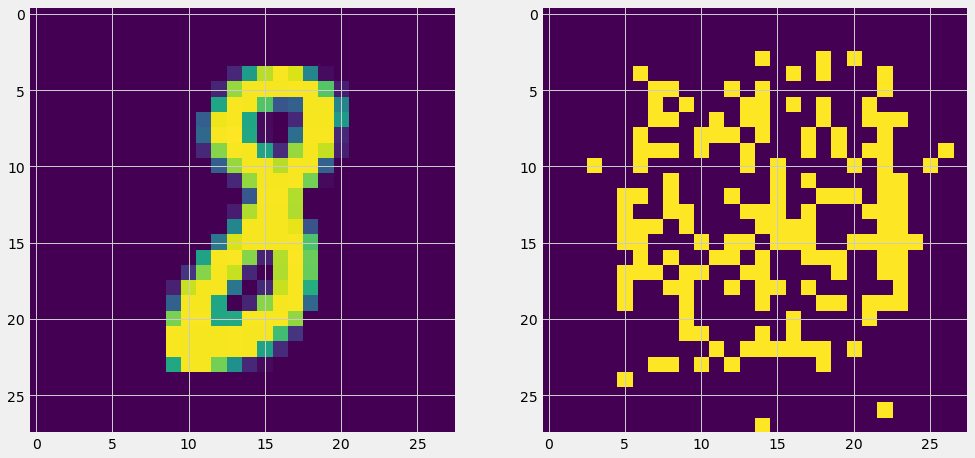

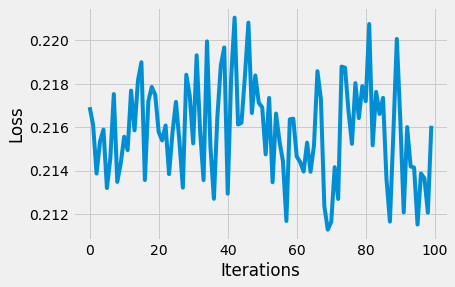

In [229]:
epochs = 5
outputs = []
losses = []
total_step = len(loader)
for epoch in range(epochs):
    for i, (image, _) in enumerate(loader):
        # Reshaping the image to (-1, 784)
        image = image.reshape(-1, 28 * 28)

        # Output of Autoencoder
        reconstructed = model(image)

        # Calculating the loss function
        loss = loss_function(reconstructed, image)

        # The gradients are set to zero,
        # the the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Storing the losses in a list for plotting
        losses.append(loss)
        if (i + 1) % 500 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, epochs, i + 1, total_step, loss.item()))
    outputs.append((epochs, image, reconstructed))
    fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (15, 8))
    img = reconstructed[-1].cpu()
    ax1.imshow(image[-1].reshape(28,28).cpu())
    ax2.imshow(img.reshape(28,28).detach().numpy())
    plt.show()

# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting the last 100 values
plt.plot(losses[-100:])

In [230]:
model.eval()


AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=36, bias=True)
    (5): ReLU()
    (6): Linear(in_features=36, out_features=18, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=18, out_features=36, bias=True)
    (1): ReLU()
    (2): Linear(in_features=36, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)

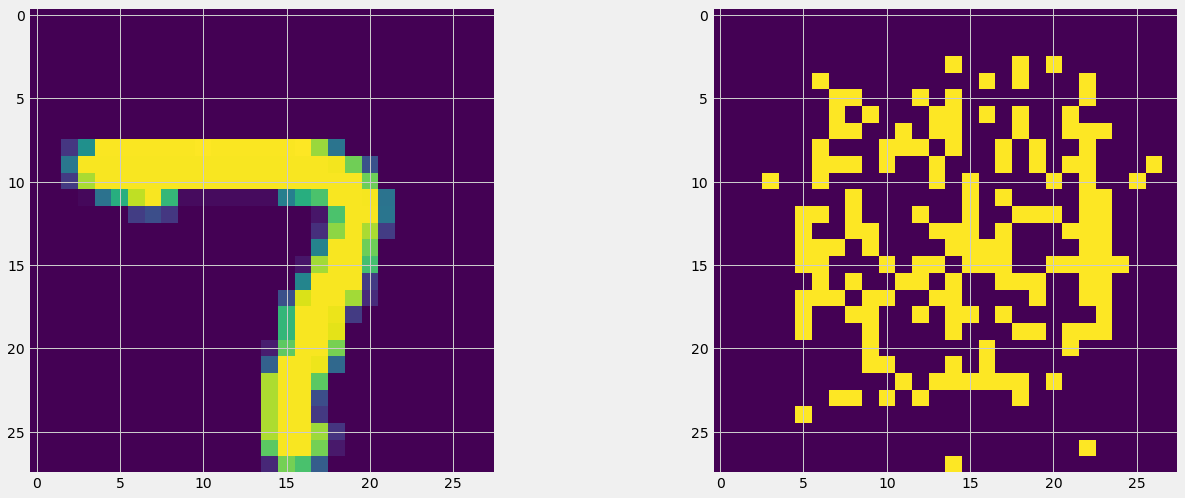

In [231]:
fig, (ax1, ax3) = plt.subplots(ncols = 2, figsize = (20, 8))
for i, item in enumerate(image):
  # Reshape the array for plotting
  item = item.reshape(-1, 28, 28)
  ax1.imshow(item[0].cpu())
  rec = model(item.reshape(-1, 28 * 28))
  ax3.imshow(rec.reshape(28,28).cpu().detach().numpy())
  plt.show()

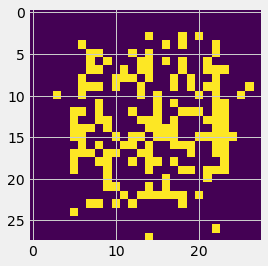

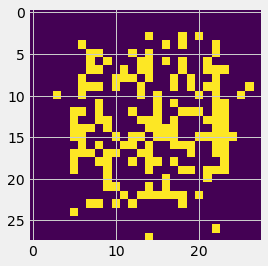

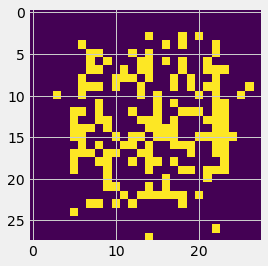

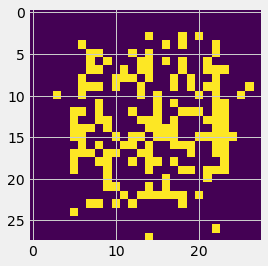

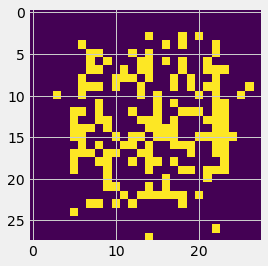

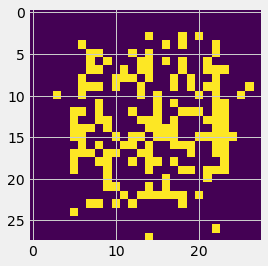

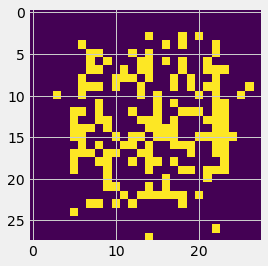

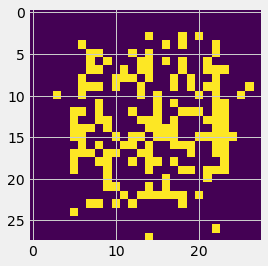

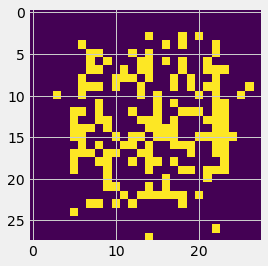

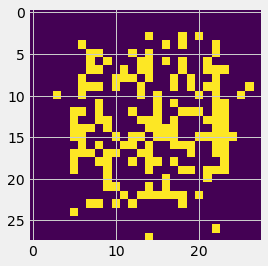

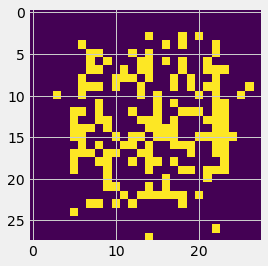

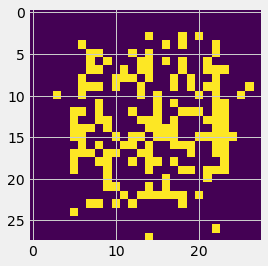

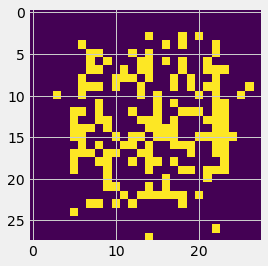

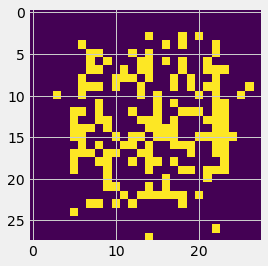

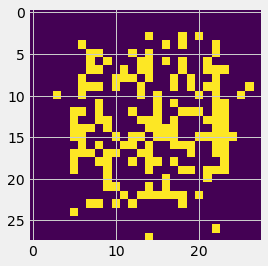

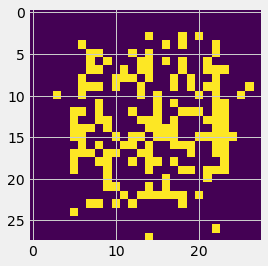

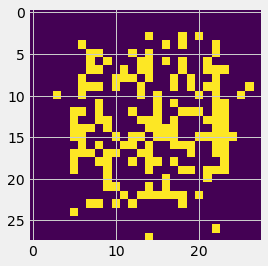

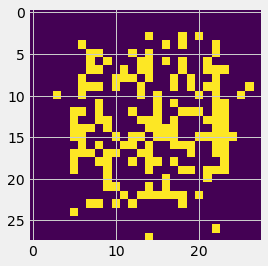

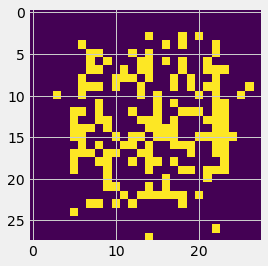

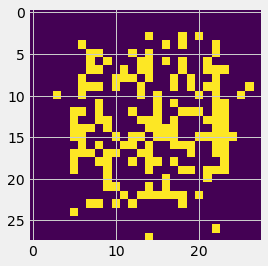

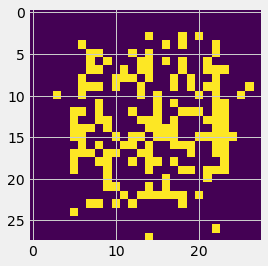

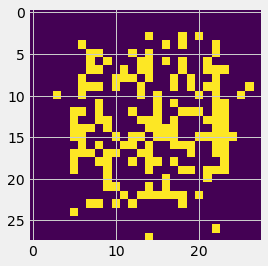

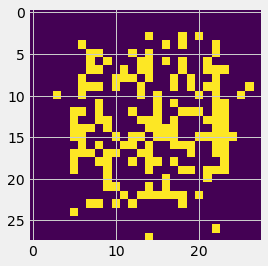

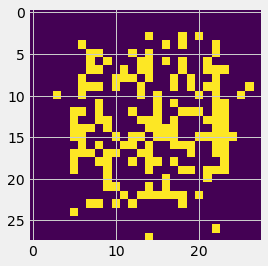

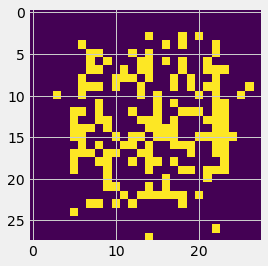

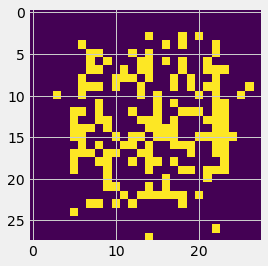

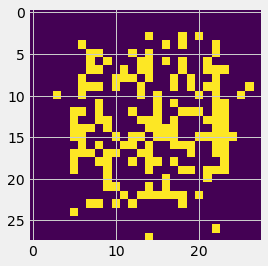

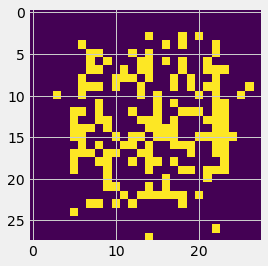

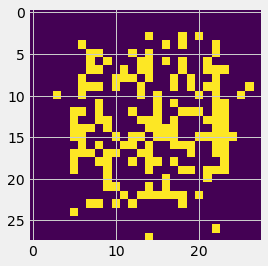

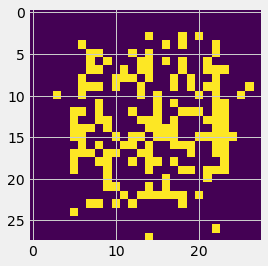

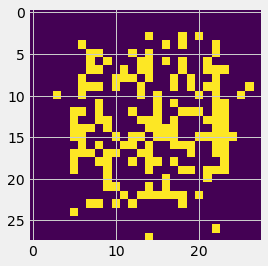

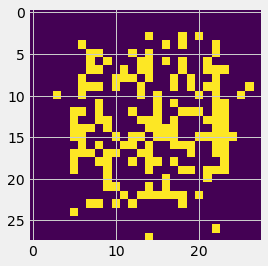

In [232]:
for rec in reconstructed:
  rec = rec.reshape(-1, 28, 28)
  plt.imshow(rec.reshape(28,28).cpu().detach().numpy())
  plt.show()